# Spielman's spectral graph sparsification [[Source]](https://arxiv.org/pdf/0808.4134.pdf)

The algorithm constructs a subgraph that has a similar Laplacian matrix to the original graph, which implies that the two graphs have similar **structural properties**.

![](./sparsification/paper-overview.png)

# high-level overview of the steps involved in Spielmans's nearly-linear time spectral graph sparsification method:


1. Compute the Laplacian matrix $L$ of the input graph $G$, which encodes the **structural properties** of the graph.
2. Compute an approximation of the effective resistance between pairs of vertices in the graph. The effective resistance measures the ease of flow between pairs of vertices in the graph, and it is closely related to the spectral properties of the Laplacian matrix.
3. Construct a new graph $H$ by sampling edges from the input graph G with probabilities proportional to the effective resistances computed in step 2. This step aims to preserve the spectral properties of the Laplacian matrix while reducing the number of edges in the graph.

The key idea behind this algorithm is to use the effective resistances to guide the edge sampling process, such that the resulting graph preserves the structural properties of the original graph while having significantly fewer edges. The nearly-linear running time of the algorithm is achieved by exploiting properties of the effective resistances and using randomized algorithms to sample the edges efficiently.

### [Note] Step 1: Laplacian matrix
Laplacian matrix L is formed by: $L = D - A$, where $D$ is the diagonal matrix of degree of vertices, and $A$ is the adjacency matrix of the graph.

For $d_{i} \in D$, $d_{i} = \sum^{n}_{j=1}A_{ij}$.

The L has the following attributes:

1. symmetric.
2. has non-negative eigenvalue spectrum, which means  $0 = \lambda_{1} \leq \lambda_{2} \leq ... \leq \lambda_{n}$.
3. positive semidefinite. Semidefinite means $X^{T}LX \geq 0$.

### [Note] Step 2: Effective resistance 

The effective resistance is a concept that arises in electrical network theory and is closely related to the spectral properties of the Laplacian matrix of a graph. It measures the ease of flow between pairs of vertices in the graph, and it can be used to characterize the connectivity and conductance properties of the graph.

The effective resistance between two vertices $u$ and $v$ in a graph can be thought of as the resistance that a unit current flowing from u to v encounters in the graph. Mathematically, we can compute the effective resistance by considering the problem of finding the effective resistance between the two vertices when all other vertices in the graph are grounded (i.e., have zero voltage).

To compute the effective resistance between $u$ and $v$, we first construct a system of linear equations based on the Kirchhoff's laws of conservation of charge and energy. We do this by setting the voltages of all vertices except u and v to zero and applying a voltage of 1 to vertex u and a voltage of -1 to vertex v. For example, if we have a graph $G$ with vertices ${v_1, v_2, v_3, v_4}$. To compute the efficient resistance between $v_1$ and $v_3$. The $e_u$ ($e_{v_1}$) is $\begin{bmatrix}1&0&0&0\end{bmatrix}$ and $e_v$ ($e_{v_3}$) is $\begin{bmatrix}0&0&-1&0\end{bmatrix}$
This gives us a system of equations of the form:

$$Lx = e_u - e_v$$

where $L$ is the Laplacian matrix of the graph, $e_u$ is a vector with a 1 in the u-th position and zeros everywhere else, and $e_v$ is a vector with a -1 in the v-th position and zeros everywhere else. The solution vector $x$ represents the voltages at each vertex in the graph.

Once we have the solution vector $x$, we can compute the effective resistance between $u$ and $v$ by taking the dot product of the vector $e_u - e_v$ with x, i.e.,

$$R_{uv} = (e_u - e_v)^T x$$

The effective resistance $R_{uv}$ is a measure of the difficulty that a unit current flowing from u to v encounters in the graph. Intuitively, it can be thought of as the amount of "friction" or "resistance" that the current experiences as it flows through the edges of the graph.

Consider above two equations, we have the final function to get effective resistance:

$$R_{u,v} = (e_u-e_v)^{T}L^{-1}(e_u-e_v)$$

Some important properties of effective resistances include:

1. Symmetry: $R_{uv} = R_{vu}$ for any pair of vertices $u$ and $v$.
2. Triangle inequality: $R_{uw} \leq R_{uv} + R_{vw}$ for any triple of vertices $u$, $v$, and $w$.
3. Positive definiteness: $R_{uv} \gt 0$ if and only if u and v are connected by an edge in the graph.

Effective resistances have many applications in graph theory and related fields, such as approximation algorithms, network analysis, and machine learning.


### [Note] Step 3: Sampling edges for graph $H$


For each edge ($u$,$v$) in the graph G, we compute the probability $p_{uv}$ that it will be included in the new graph H. This probability is proportional to the effective resistance value $R_{uv}$ of the edge, i.e., $p_{uv} = C * R_{uv}$, where $C$ is a normalization constant that ensures the expected number of edges in $H$ is close to the desired sparsity. Typically, $C$ can be set to $2m/tr(L)$, where m is the number of edges in $G$ and $tr(L)$ is the trace (sum of diagonal entries, $tr(A)=\sum A_{ii}$) of the Laplacian matrix of $G$.

We independently sample each edge ($u$,$v$) from the graph G with probability $p_{uv}$, and add it to the new graph $H$. This gives us a sparse subgraph $H$ that consists of a subset of the edges from $G$. The number of edges in the new graph $H$ is typically much smaller than that of the original graph $G$, but it still preserves the spectral properties of $G$.

Overall, the goal of this algorithm is to construct a sparse graph $H$ from the original graph $G$ that can be more efficiently used for algorithms and analysis, without significantly affecting the spectral properties of $G$. This algorithm has been widely applied in fields such as graph partitioning, graph compression, and graph embedding, and has been shown to be highly effective in many applications.

In $G$, edges with higher effective resistance values will have higher probabilities of being included in the new graph $H$, since their contribution to the effective resistance is larger. This means that edges that are "important" in terms of their role in connecting different parts of the graph will have higher probabilities of being preserved in the sparsification process.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from BIRCH import graph

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load gaze_df 
gaze_df = pd.read_csv("gaze.csv")

In [3]:
img_width, img_height = 2544, 3056
G = graph.generate_graph_from_gaze_df(gaze_df =gaze_df, img_width=img_width, img_height=img_height)

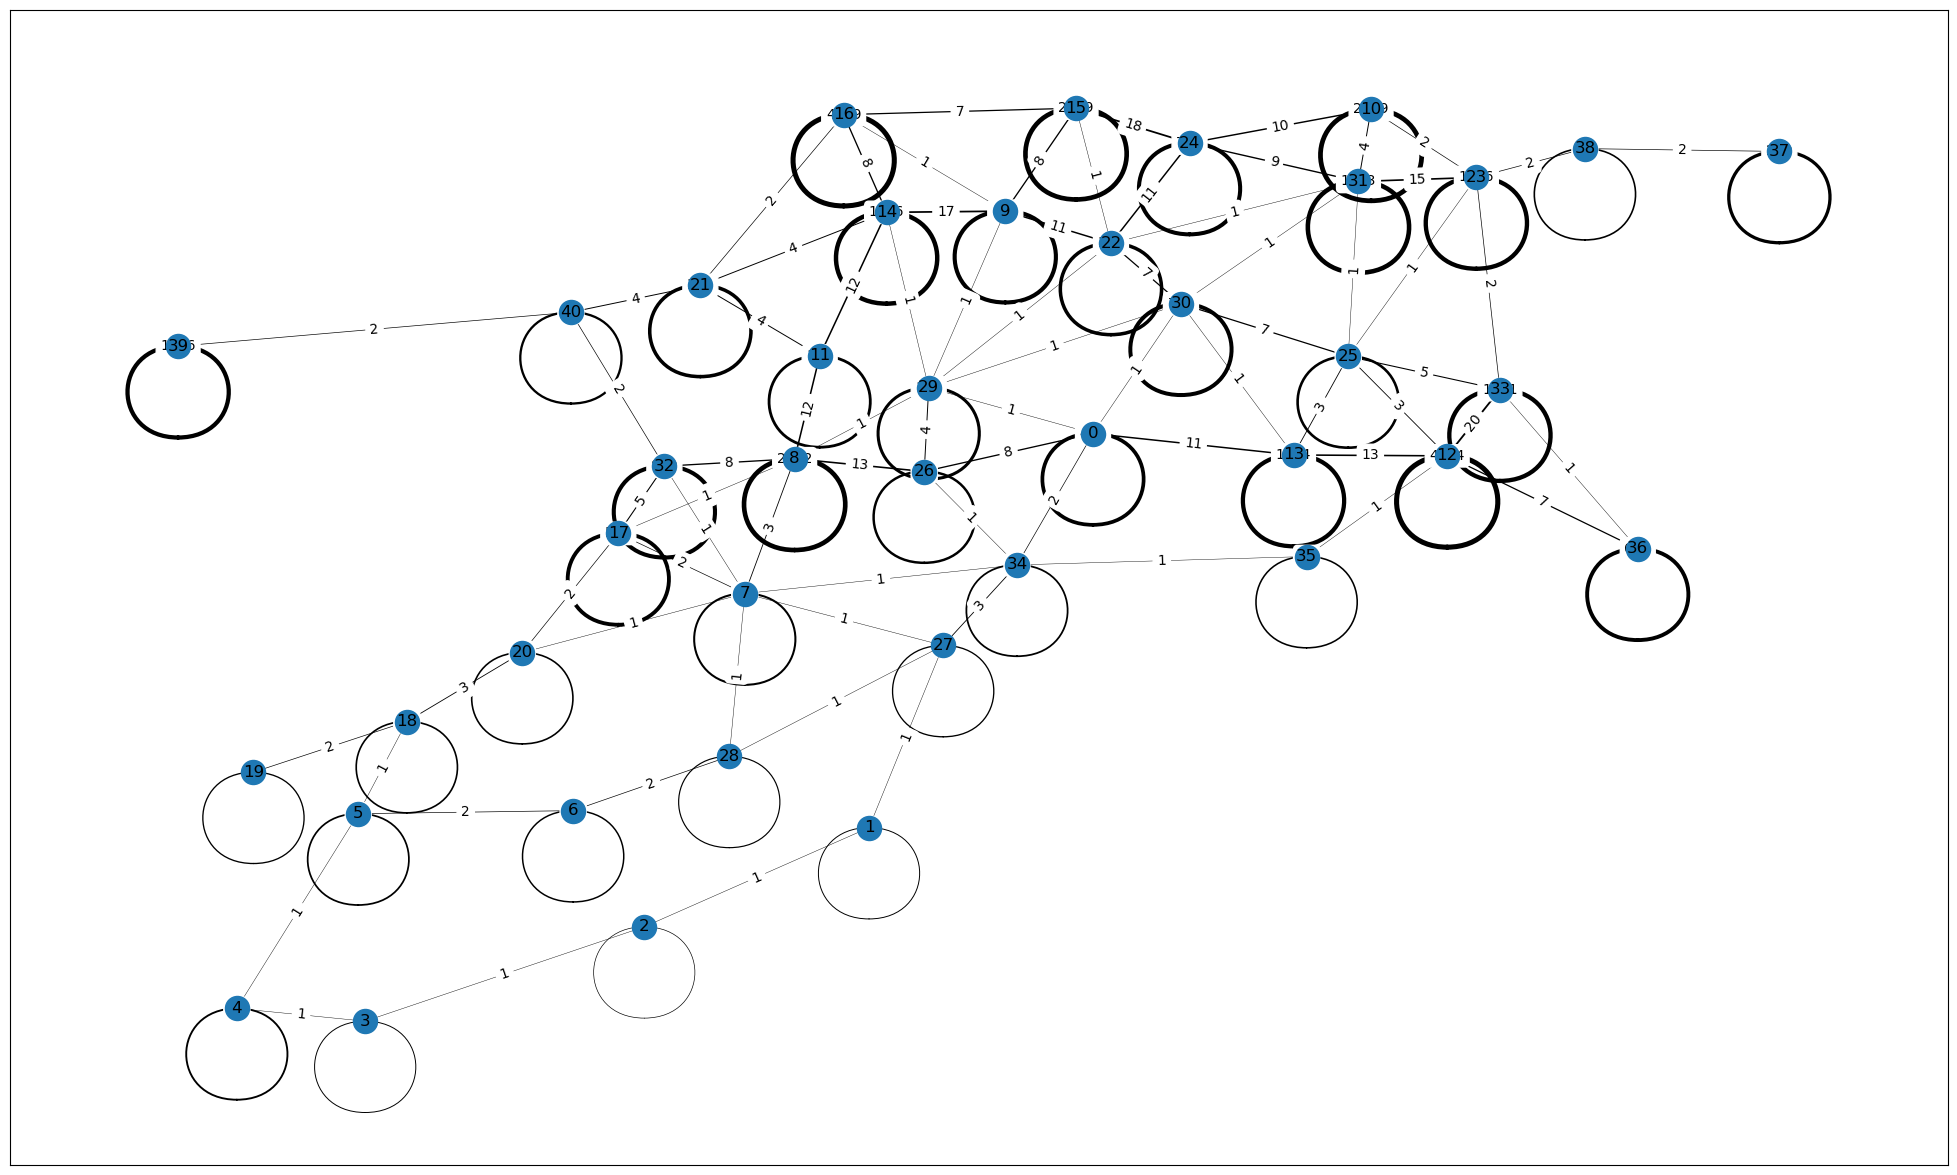

In [4]:
graph.visualise_graph_with_weights(G)

## Equations overview

In the paper (https://arxiv.org/pdf/1802.06260.pdf), the authors provide a custom way to weight edges by:

$$ w_{i,j} = exp(-N_{i}^{2} \times C_{in})^{-1} \times exp(-Ｎ_{j}^{2} \times C_{jn})^{-1} $$

Where $N_{i}$ and $N_{j}$ are number of nodes in the cluster $i$ and $j$, respectively, and $C_{in}$ and $C_{jn}$ are number of self-loops for cluster $i$ and $j$.

And, the edge will be sampled with prob. proportional to $w_{i,j} \dot r_{i.j}$, where $r_{i,j}$ is the effective resistance.

Since how $r_{i,j}$ computed is not mentioned in this paper, I assumed they follow the same algorithm in Spielman's paper (https://arxiv.org/pdf/1802.06260.pdf).

And in the Spielman's paper, the effective resistance is calculated by:

$$R_{u,v} = (e_u-e_v)^{T}L^{+}(e_u-e_v),$$

where $x_{u}$ is the elementary unit vector with a coordinate 1 in position $u$. And, $L^{+}$ is the pseudoinverse of $L$.

And, $L$ is the Laplacian of weighted graph given by $L = D - A$, where A is the weighted adjacency matrix $(a_{ij}) = w_{ij}$ and $D$ is the diagonal matrix $(d_{ii}) = \sum_{j \neq i} w_{ij} $

# [Step 1]: Get $L$

In [5]:
n = G.number_of_nodes()
m = G.number_of_edges()

# so first, we get the matrix
L = nx.laplacian_matrix(G).todense()
A = nx.adjacency_matrix(G).todense()

In here, I found the way `networkx` implemented laplacian matrix is to ignore the self loops, they will be considered in the custom weights.

In [6]:
np.fill_diagonal(A, 0)

In [7]:
# calculate D
D =  np.diag(np.sum(A, axis=1).flatten().tolist()[0])
L_ = D - A

In [8]:
(L_ == L).all()

True

# [Step 2]: Compute prob. for edges.

Once $L$ is obtained, we can have our effective resistance using: 
$$R_{u,v} = (e_u-e_v)^{T}L^{+}(e_u-e_v),$$

And the custom weight is defined as:

$$ w_{u,v} = exp(-N_{u}^{2} \times C_{un})^{-1} \times exp(-Ｎ_{v}^{2} \times C_{vn})^{-1} $$

In [9]:
L_plus = np.linalg.pinv(L)
effective_resistance = np.zeros(m)
custom_weights = np.zeros(m)
for i, (u, v) in enumerate(G.edges()):
    data = G.get_edge_data(u, v)
    e_u = np.zeros(n)
    e_u[u] = 1
    e_v = np.zeros(n)
    e_v[v] = 1

    R_uv = (e_u-e_v).T @ L_plus @ (e_u-e_v)
    effective_resistance[i] = R_uv

    N_u = G.nodes[u]['N']
    N_v = G.nodes[v]['N']
    C_u = G.nodes[u]['C']
    C_v = G.nodes[v]['C']

    # custom_weights[i] = (np.exp(-(N_u**2)*C_u)**(-1)) * (np.exp(-np.power(N_v,2)*C_v)**(-1)) # according to the paper,
    custom_weights[i] = np.e**((-(N_u**2)*C_u).astype(float)**(-1)) * np.e**((-(N_v**2)*C_v).astype(float)**(-1)) #

# Formula?

When the implementation is done as described in the paper. We're easily to have `overflow` and `divided by 0` issues.

According to their statement, "That is, higher values of weight correspond to higher focus of attention on a corresponding cluster centroid.", I found what's the formula really look like.

Instead of listing out the formula as above, it should be written as:

$$ w_{u,v} = e^{(-N_{u}^{2} \times C_{un})^{-1}} \times e^{(-Ｎ_{v}^{2} \times C_{vn})^{-1}} $$

or

$$ w_{u,v} = e^{((-N_{u}^{2} \times C_{un})^{-1})} \times e^{((-Ｎ_{v}^{2} \times C_{vn})^{-1})} $$


### Multiply custom weights and effective resistance
This give us the probability to sample the edges.

In [10]:
combined_weights = custom_weights * effective_resistance
p = combined_weights / np.sum(combined_weights)

# [Step 3]: Generate sparse graph $H$

In here, we first setup how many edges we want to sample from $G$, which also means how many edges $H$ will have.

In [11]:
print(f"Originally, we have {m} edges")

Originally, we have 118 edges


In [12]:
k = 50

In [13]:
H = nx.Graph()
H.add_nodes_from(G.nodes(data=True))
sampled_edges = np.random.choice(m, size=k, replace=False, p=p)
for i in sampled_edges:
    u, v = list(G.edges())[i]
    H.add_edge(u, v, weight=G.edges()[u,v]['weight'])

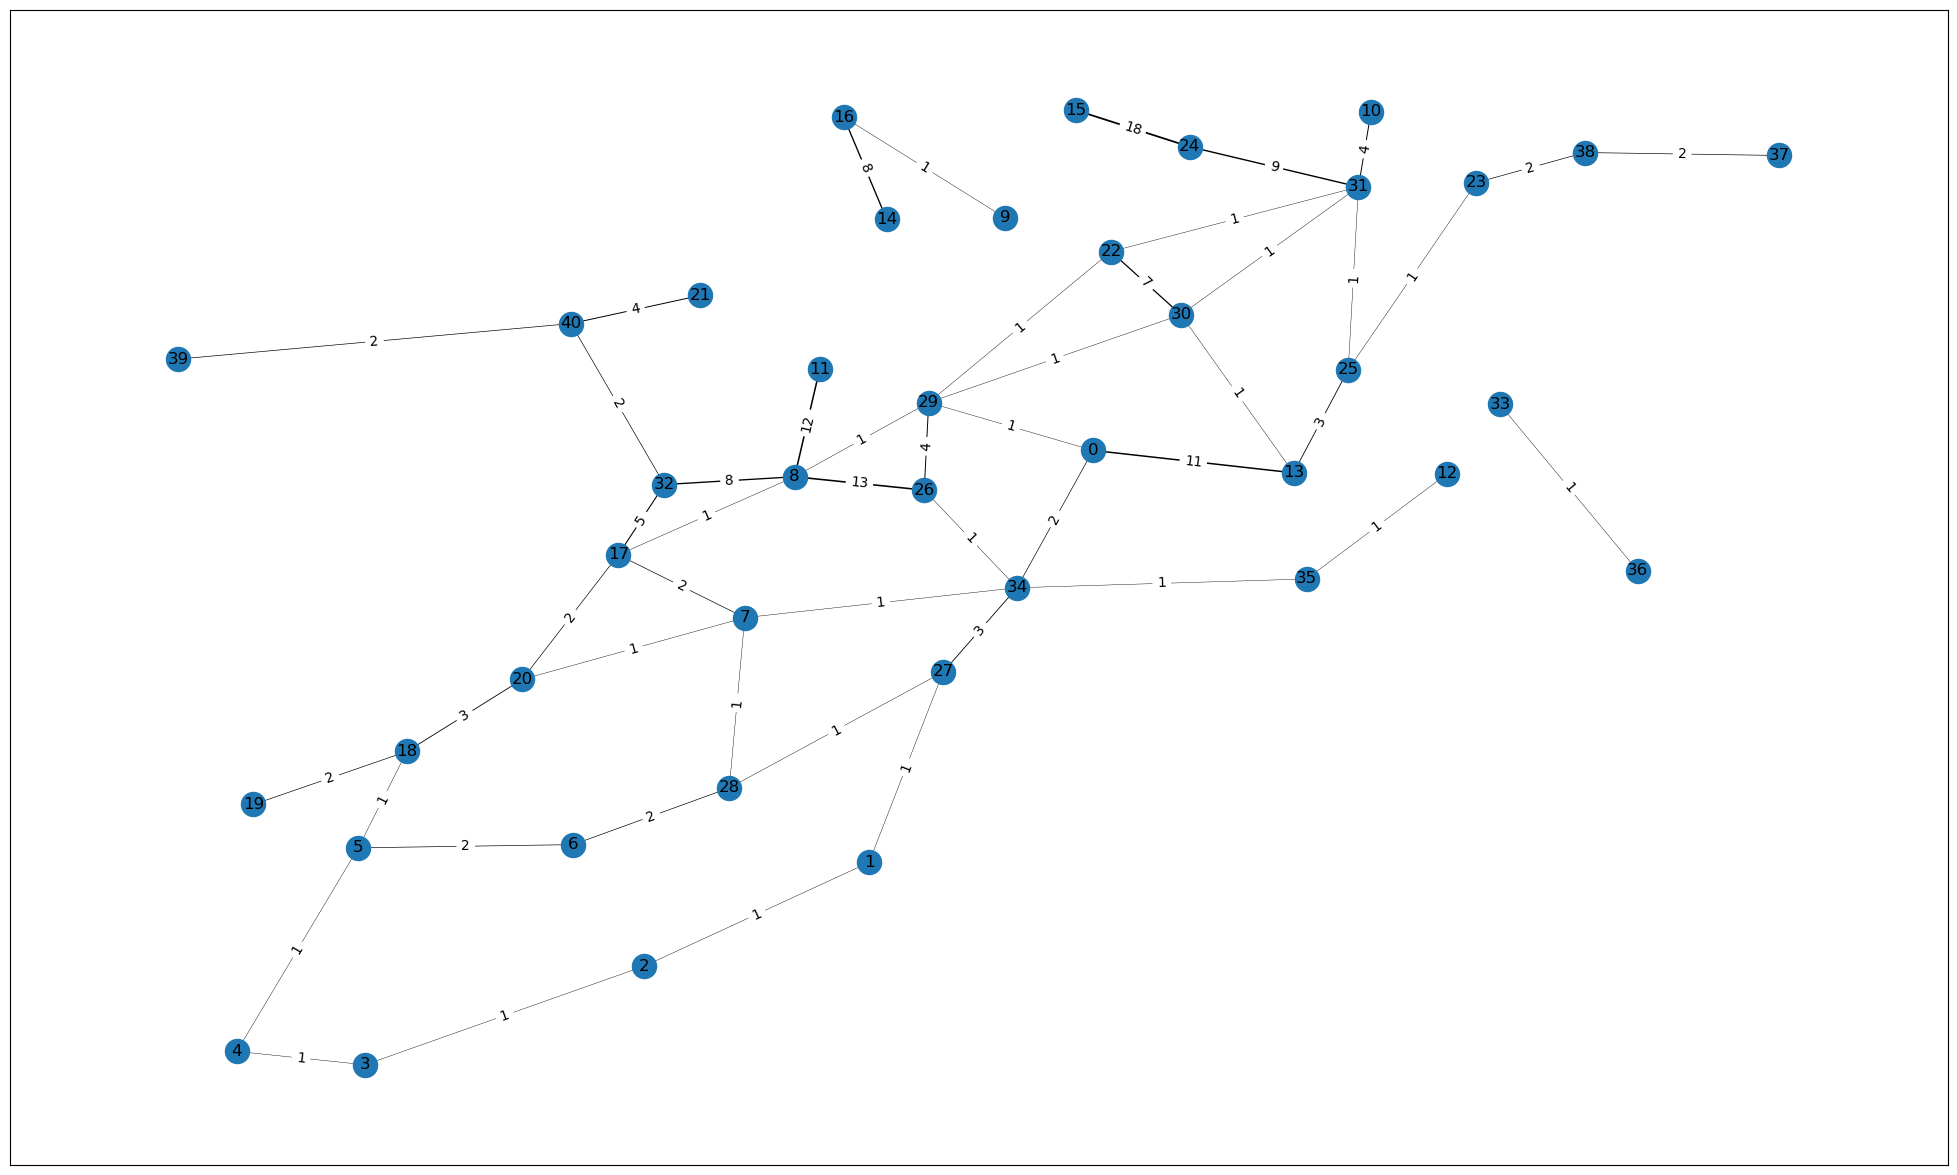

In [14]:
graph.visualise_graph_with_weights(H)

#### [**Q**]: Did they remove the isolated nodes? 

The return $S$ has the same $V$, so it shouldn't be.

![](./sparsification/paper-alg.png)

In [15]:
H.remove_nodes_from(list(nx.isolates(H)))

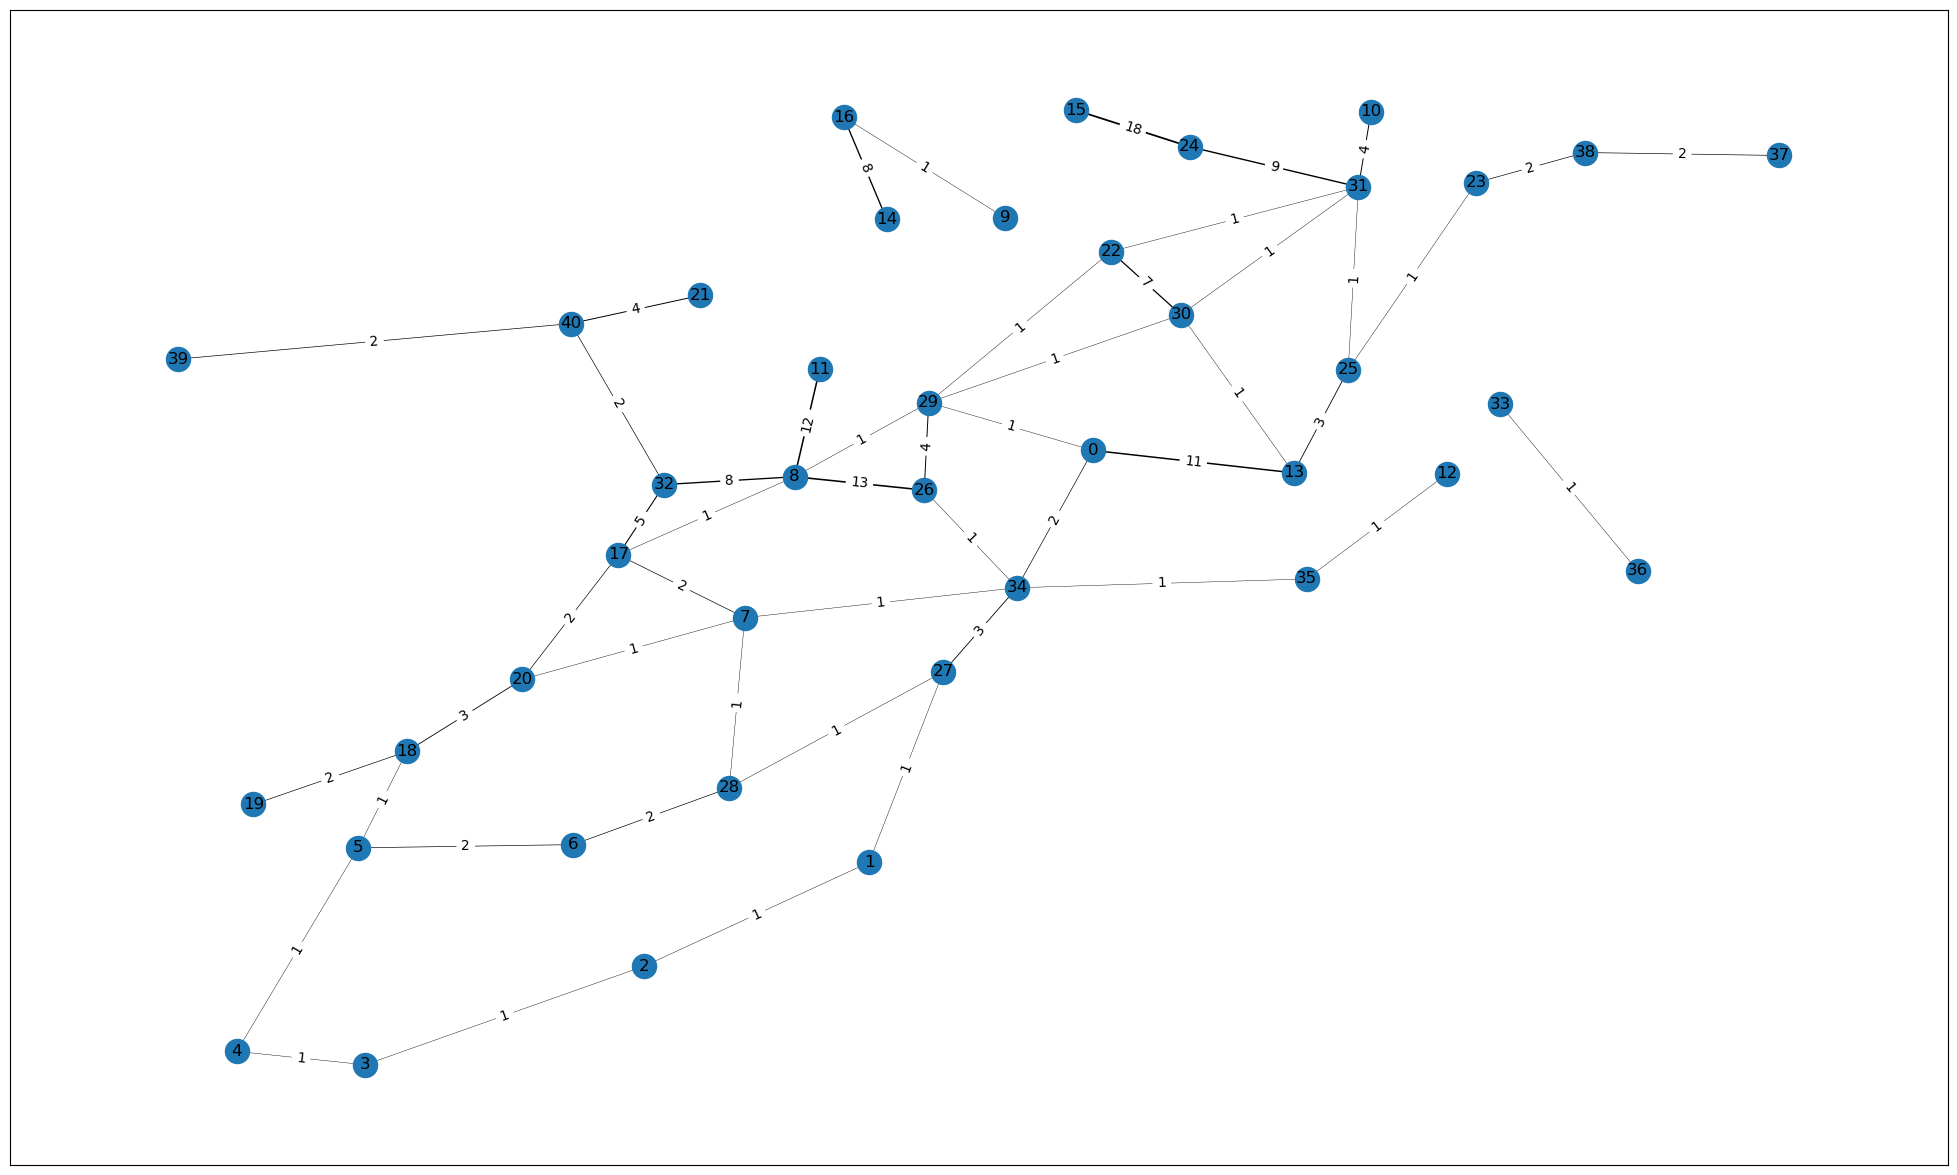

In [16]:
graph.visualise_graph_with_weights(H)